In [1]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt

# import ROOT
# import event_processing_v4
# import postgresql_v3_event_storage
# import dataset_query_functions_v3
# import tool.npy_frames_visualization as npy_vis
# import tool.acqconv
# from data_analysis_utils import *
# from event_recognition_efficiency_v3 import *
# import supervised_classification as supc

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
# from tool.misc.event_analysis_record_v3_6_update import EventAnalysisRecordV3_6_update
import dataset_query_functions_v3

#import ROOT

# import tool.npy_frames_visualization as npy_vis
import tool.acqconv
from data_analysis_utils import *
from event_recognition_efficiency_v3 import *
# import supervised_classification as supc    

Welcome to JupyROOT 6.13/02


In [3]:
data_snippents_dir = 'ver4_flatmap_data_snippets'
os.makedirs(data_snippents_dir, exist_ok=True)

In [4]:
event_processing_cls = event_processing_v4.EventProcessingV4
# event_processing_cls.event_analysis_record_class = EventAnalysisRecordV3_6_update
event_v3_storage_provider = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider)

In [5]:
columns_for_analysis_dict = query_functions.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=[
        ('^$',None), 
        'gtu_datetime_mean', 'gps_alt_mean', 'gps_lon_mean', 'gps_lat_mean', 
        ('trg_box_per_gtu|trg_pmt_per_gtu|trg_ec_per_gtu|n_persist|gtu_in_persist','mean|max'),
        'orig_x_y_max', 'orig_x_y_sum',
        'trg_count_nonzero',
        
        '(proc|trg)\d_(x|gtu)_(x|y)_clusters_count',
        '(proc|trg)\d_(x|gtu)_(x|y)_clusters_sizes_mean',
        '(proc|trg)\d_(x|gtu)_(x|y)_clusters_sizes_max',
        '(proc|trg)\d_(x|gtu)_(x|y)_clusters_max_peak_clu_size',
        
        '(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_line_clusters_max_peak_clu_height$',
        '(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_line_clusters_max_peak_clu_width$',
        '(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_max_clu_major_line_phi$',
        '(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_max_clu_major_line_rho$',
        '(proc|trg|alt)\d_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_major_line_phi$',
        '(proc|trg|alt)\d_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_major_line_rho$',
        
        ]
)

In [6]:
tot_columns = 0
for t, vl in columns_for_analysis_dict.items():
    sys.stdout.write(t)
    sys.stdout.write('\n\t- ')
    print('\n\t- '.join(vl))
    print()
    tot_columns += len(vl)
print('-'*60)
print(tot_columns)

spb_processing_v4_flatmap.event
	- event_id
	- config_info_id
	- program_version
	- timestamp
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu
	- source_data_type_num

spb_processing_v4_flatmap.event_trg_box_per_gtu
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_trg_pmt_per_gtu
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_trg_ec_per_gtu
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_n_persist
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_gtu_in_persist
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_gps_lat
	- mean

spb_processing_v4_flatmap.event_gps_lon
	- mean

spb_processing_v4_flatmap.event_gps_alt
	- mean

spb_processing_v4_flatmap.event_gtu_datetime
	- mean

spb_processing_v4_flatmap.event_orig_x_y
	- sum
	- max

spb_processing_v4_flatmap.event_proc1_x_y_clusters
	- count
	- sizes_max
	- sizes_mean
	- ma

In [7]:
current_columns_for_analysis_dict = columns_for_analysis_dict

select_clause_str, joined_tables_list = \
    query_functions.get_query_clauses__select(current_columns_for_analysis_dict)
join_clauses_str = \
    query_functions.get_query_clauses__join(joined_tables_list)
where_clauses_str = ''
    
events_selection_query = query_functions.get_events_selection_query_plain(
    source_data_type_num=1,
    select_additional=select_clause_str, join_additional=join_clauses_str,
    where_additional=where_clauses_str,
    order_by='{data_table_name}.event_id', limit=350000, offset=0,
    base_select='',
#     data_table_name_overwrite=events_data_table_name
)

In [8]:
flight_bg05_df = psql.read_sql(events_selection_query, event_v3_storage_provider.connection)

In [21]:
print('len(flight_bg05_df) =',len(flight_bg05_df))

len(flight_bg05_df) = 243314


In [22]:
flight_bg05_df.head()

,event_id,config_info_id,program_version,timestamp,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,...,alt1_gtu_x_hough_peak_thr2_major_line_phi,alt1_gtu_x_hough_peak_thr2_major_line_rho,alt1_gtu_x_hough_peak_thr3_major_line_phi,alt1_gtu_x_hough_peak_thr3_major_line_rho,alt1_gtu_y_hough_peak_thr1_major_line_phi,alt1_gtu_y_hough_peak_thr1_major_line_rho,alt1_gtu_y_hough_peak_thr2_major_line_phi,alt1_gtu_y_hough_peak_thr2_major_line_rho,alt1_gtu_y_hough_peak_thr3_major_line_phi,alt1_gtu_y_hough_peak_thr3_major_line_rho
0,1,1,4.7,1537088438,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170428-063224...,trn_20170428-063224-001.001_C_inverse_flat_ave...,40,0,...,1.584360,12.86900,1.64850,12.38460,1.589630,4.05725,1.595110,4.00026,1.559790,4.55642
1,2,1,4.7,1537088440,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170428-063224...,trn_20170428-063224-001.001_C_inverse_flat_ave...,84,0,...,6.270380,15.59760,6.24887,17.05470,1.551250,4.65179,1.208270,8.96600,0.833663,10.27450
2,3,1,4.7,1537088442,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170428-063224...,trn_20170428-063224-001.001_C_inverse_flat_ave...,167,1,...,6.250160,6.61775,6.19447,6.58003,0.013085,7.02388,6.266010,6.97864,0.338427,9.98903
3,4,1,4.7,1537088443,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170428-063224...,trn_20170428-063224-001.001_C_inverse_flat_ave...,296,2,...,1.622270,9.23745,1.66152,9.39496,1.555520,4.19350,1.558680,4.22611,1.550620,4.51166
4,5,1,4.7,1537088446,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170428-063224...,trn_20170428-063224-001.001_C_inverse_flat_ave...,424,3,...,0.059669,9.70873,0.03767,6.81746,0.966610,9.77459,0.936789,10.12240,0.958419,10.11380


# Number of events per time (bgf 0.5)

In [9]:
import math
import datetime

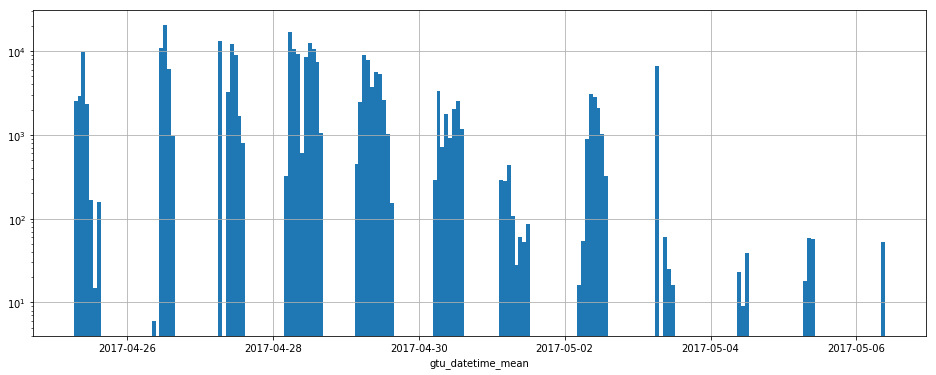

In [26]:
ha = flight_bg05_df.gtu_datetime_mean.hist(bins=208, figsize=(16,6))
ha.set_xlabel('gtu_datetime_mean')
ha.set_yscale('log')
plt.show()

0    1493094708.45 (2017-04-25 04:31:48.450795) 1493112708.45 (2017-04-25 09:31:48.450795) 8015   


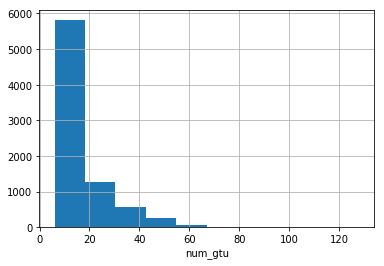

1    1493112708.45 (2017-04-25 09:31:48.450795) 1493130708.45 (2017-04-25 14:31:48.450795) 9784   


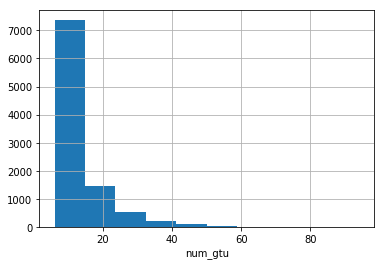

2    1493130708.45 (2017-04-25 14:31:48.450795) 1493148708.45 (2017-04-25 19:31:48.450795) 157    


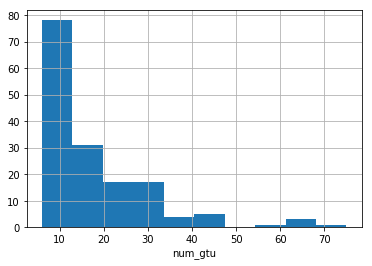

3    1493148708.45 (2017-04-25 19:31:48.450795) 1493166708.45 (2017-04-26 00:31:48.450795) 0      
4    1493166708.45 (2017-04-26 00:31:48.450795) 1493184708.45 (2017-04-26 05:31:48.450795) 0      
5    1493184708.45 (2017-04-26 05:31:48.450795) 1493202708.45 (2017-04-26 10:31:48.450795) 6      


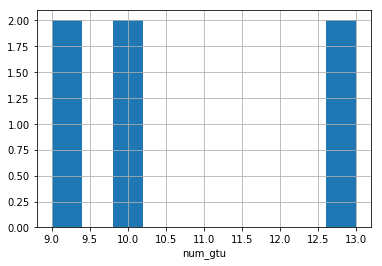

6    1493202708.45 (2017-04-26 10:31:48.450795) 1493220708.45 (2017-04-26 15:31:48.450795) 38505  


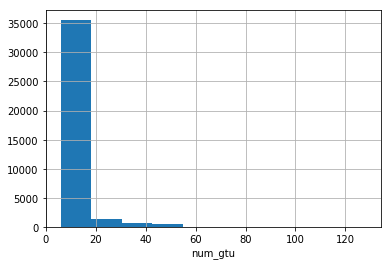

7    1493220708.45 (2017-04-26 15:31:48.450795) 1493238708.45 (2017-04-26 20:31:48.450795) 0      
8    1493238708.45 (2017-04-26 20:31:48.450795) 1493256708.45 (2017-04-27 01:31:48.450795) 0      
9    1493256708.45 (2017-04-27 01:31:48.450795) 1493274708.45 (2017-04-27 06:31:48.450795) 2861   


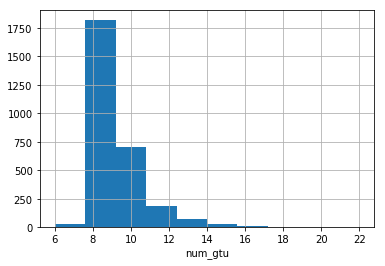

10   1493274708.45 (2017-04-27 06:31:48.450795) 1493292708.45 (2017-04-27 11:31:48.450795) 30083  


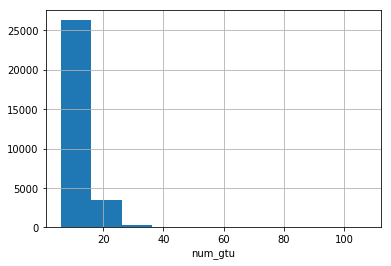

11   1493292708.45 (2017-04-27 11:31:48.450795) 1493310708.45 (2017-04-27 16:31:48.450795) 7227   


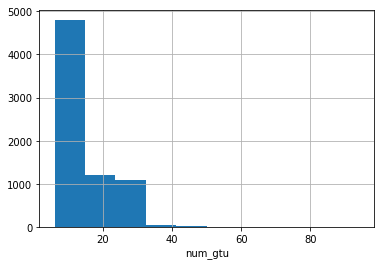

12   1493310708.45 (2017-04-27 16:31:48.450795) 1493328708.45 (2017-04-27 21:31:48.450795) 0      
13   1493328708.45 (2017-04-27 21:31:48.450795) 1493346708.45 (2017-04-28 02:31:48.450795) 0      
14   1493346708.45 (2017-04-28 02:31:48.450795) 1493364708.45 (2017-04-28 07:31:48.450795) 24747  


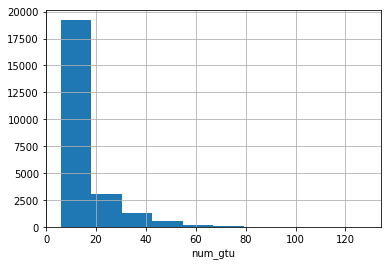

15   1493364708.45 (2017-04-28 07:31:48.450795) 1493382708.45 (2017-04-28 12:31:48.450795) 30769  


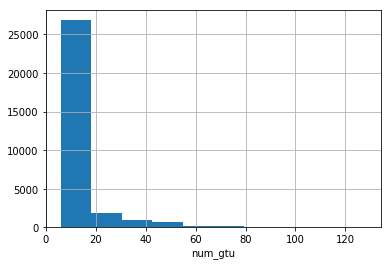

16   1493382708.45 (2017-04-28 12:31:48.450795) 1493400708.45 (2017-04-28 17:31:48.450795) 21742  


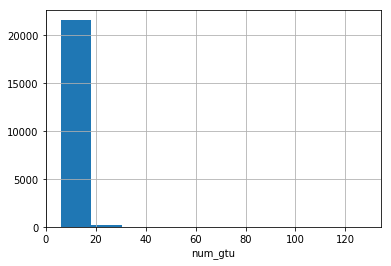

17   1493400708.45 (2017-04-28 17:31:48.450795) 1493418708.45 (2017-04-28 22:31:48.450795) 0      
18   1493418708.45 (2017-04-28 22:31:48.450795) 1493436708.45 (2017-04-29 03:31:48.450795) 0      
19   1493436708.45 (2017-04-29 03:31:48.450795) 1493454708.45 (2017-04-29 08:31:48.450795) 20895  


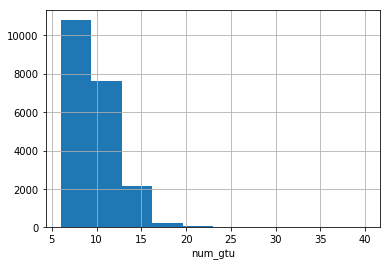

20   1493454708.45 (2017-04-29 08:31:48.450795) 1493472708.45 (2017-04-29 13:31:48.450795) 15991  


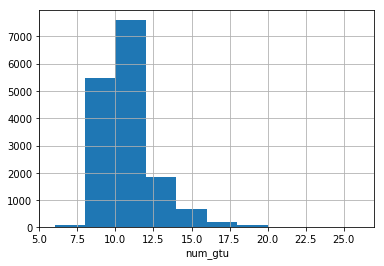

21   1493472708.45 (2017-04-29 13:31:48.450795) 1493490708.45 (2017-04-29 18:31:48.450795) 1171   


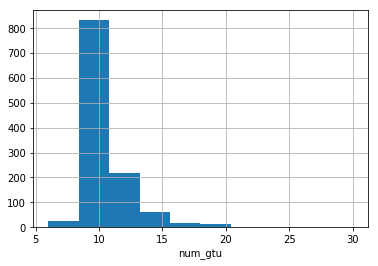

22   1493490708.45 (2017-04-29 18:31:48.450795) 1493508708.45 (2017-04-29 23:31:48.450795) 0      
23   1493508708.45 (2017-04-29 23:31:48.450795) 1493526708.45 (2017-04-30 04:31:48.450795) 0      
24   1493526708.45 (2017-04-30 04:31:48.450795) 1493544708.45 (2017-04-30 09:31:48.450795) 5766   


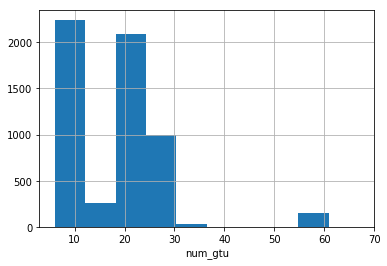

25   1493544708.45 (2017-04-30 09:31:48.450795) 1493562708.45 (2017-04-30 14:31:48.450795) 6953   


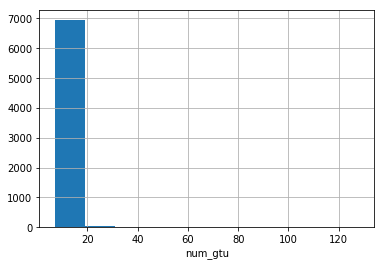

26   1493562708.45 (2017-04-30 14:31:48.450795) 1493580708.45 (2017-04-30 19:31:48.450795) 54     


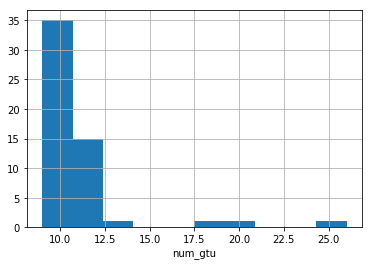

27   1493580708.45 (2017-04-30 19:31:48.450795) 1493598708.45 (2017-05-01 00:31:48.450795) 0      
28   1493598708.45 (2017-05-01 00:31:48.450795) 1493616708.45 (2017-05-01 05:31:48.450795) 725    


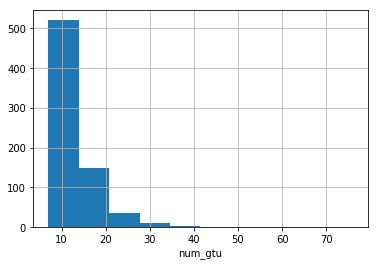

29   1493616708.45 (2017-05-01 05:31:48.450795) 1493634708.45 (2017-05-01 10:31:48.450795) 482    


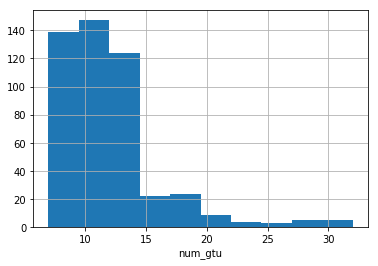

30   1493634708.45 (2017-05-01 10:31:48.450795) 1493652708.45 (2017-05-01 15:31:48.450795) 139    


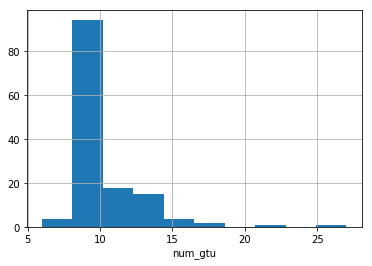

31   1493652708.45 (2017-05-01 15:31:48.450795) 1493670708.45 (2017-05-01 20:31:48.450795) 0      
32   1493670708.45 (2017-05-01 20:31:48.450795) 1493688708.45 (2017-05-02 01:31:48.450795) 0      
33   1493688708.45 (2017-05-02 01:31:48.450795) 1493706708.45 (2017-05-02 06:31:48.450795) 70     


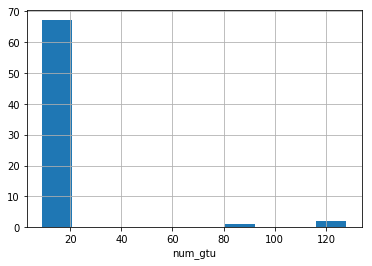

34   1493706708.45 (2017-05-02 06:31:48.450795) 1493724708.45 (2017-05-02 11:31:48.450795) 8509   


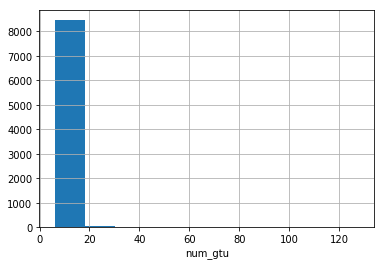

35   1493724708.45 (2017-05-02 11:31:48.450795) 1493742708.45 (2017-05-02 16:31:48.450795) 1718   


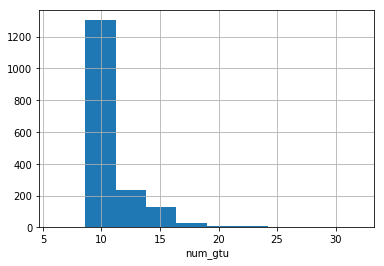

36   1493742708.45 (2017-05-02 16:31:48.450795) 1493760708.45 (2017-05-02 21:31:48.450795) 0      
37   1493760708.45 (2017-05-02 21:31:48.450795) 1493778708.45 (2017-05-03 02:31:48.450795) 0      
38   1493778708.45 (2017-05-03 02:31:48.450795) 1493796708.45 (2017-05-03 07:31:48.450795) 6587   


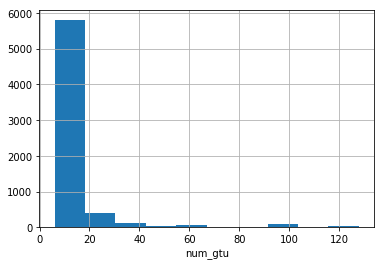

39   1493796708.45 (2017-05-03 07:31:48.450795) 1493814708.45 (2017-05-03 12:31:48.450795) 101    


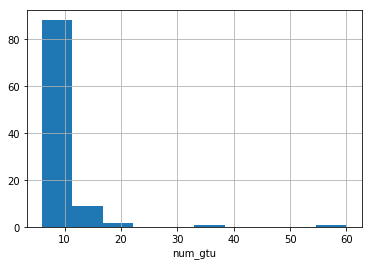

40   1493814708.45 (2017-05-03 12:31:48.450795) 1493832708.45 (2017-05-03 17:31:48.450795) 0      
41   1493832708.45 (2017-05-03 17:31:48.450795) 1493850708.45 (2017-05-03 22:31:48.450795) 0      
42   1493850708.45 (2017-05-03 22:31:48.450795) 1493868708.45 (2017-05-04 03:31:48.450795) 0      
43   1493868708.45 (2017-05-04 03:31:48.450795) 1493886708.45 (2017-05-04 08:31:48.450795) 0      
44   1493886708.45 (2017-05-04 08:31:48.450795) 1493904708.45 (2017-05-04 13:31:48.450795) 71     


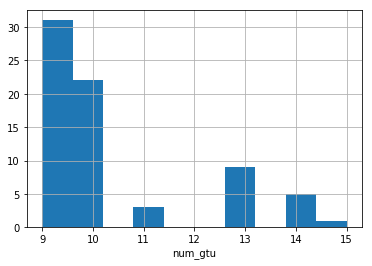

45   1493904708.45 (2017-05-04 13:31:48.450795) 1493922708.45 (2017-05-04 18:31:48.450795) 0      
46   1493922708.45 (2017-05-04 18:31:48.450795) 1493940708.45 (2017-05-04 23:31:48.450795) 0      
47   1493940708.45 (2017-05-04 23:31:48.450795) 1493958708.45 (2017-05-05 04:31:48.450795) 0      
48   1493958708.45 (2017-05-05 04:31:48.450795) 1493976708.45 (2017-05-05 09:31:48.450795) 97     


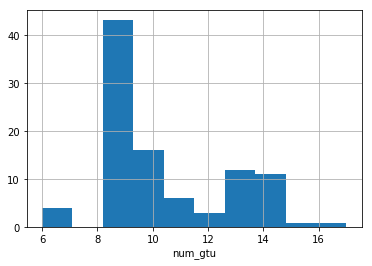

49   1493976708.45 (2017-05-05 09:31:48.450795) 1493994708.45 (2017-05-05 14:31:48.450795) 36     


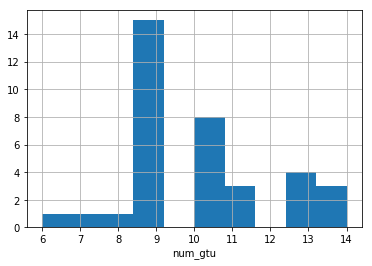

50   1493994708.45 (2017-05-05 14:31:48.450795) 1494012708.45 (2017-05-05 19:31:48.450795) 0      
51   1494012708.45 (2017-05-05 19:31:48.450795) 1494030708.45 (2017-05-06 00:31:48.450795) 0      
52   1494030708.45 (2017-05-06 00:31:48.450795) 1494048708.45 (2017-05-06 05:31:48.450795) 0      
53   1494048708.45 (2017-05-06 05:31:48.450795) 1494066708.45 (2017-05-06 10:31:48.450795) 53     


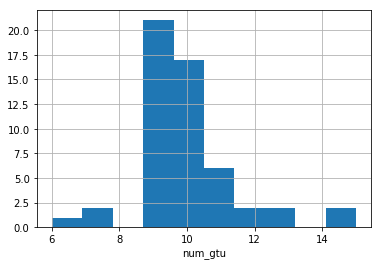

54   1494066708.45 (2017-05-06 10:31:48.450795) 1494084708.45 (2017-05-06 15:31:48.450795) 0      


In [11]:
#hist
bins_offset = flight_bg05_df.gtu_datetime_mean.min().timestamp()
bins_range_end = flight_bg05_df.gtu_datetime_mean.max().timestamp()
bin_width = 3600*5

mean_gtu_datetime_vals = []
count_entries = []

mean_num_gtu_vals = []
median_num_gtu_vals = []
quantile_025_num_gtu_vals = []
quantile_975_num_gtu_vals = []
std_num_gtu_vals = []


for i in range(0,math.ceil((bins_range_end - bins_offset)/bin_width)+1):
    min_v = bins_offset + i*bin_width
    max_v = min_v + bin_width
    t_filtered_df = flight_bg05_df[
        (datetime.datetime.utcfromtimestamp(min_v) <= flight_bg05_df.gtu_datetime_mean) \
        & (flight_bg05_df.gtu_datetime_mean < datetime.datetime.utcfromtimestamp(max_v))]
    
    print("{:<4d} {:<5.2f} ({}) {:<5.2f} ({}) {:<6d} ".format(
        i, min_v, datetime.datetime.utcfromtimestamp(min_v), max_v, datetime.datetime.utcfromtimestamp(max_v),
        len(t_filtered_df)
    ))
    if len(t_filtered_df) > 0:
        mean_gtu_datetime_vals.append(datetime.datetime.utcfromtimestamp(np.mean([min_v,max_v])))
        count_entries.append(len(t_filtered_df))
        mean_num_gtu_vals.append(t_filtered_df.num_gtu.mean())
        median_num_gtu_vals.append(t_filtered_df.num_gtu.median())
        quantile_025_num_gtu_vals.append(t_filtered_df.num_gtu.quantile(0.025))
        quantile_975_num_gtu_vals.append(t_filtered_df.num_gtu.quantile(0.975))
        std_num_gtu_vals.append(t_filtered_df.num_gtu.std())
    
        
        ha = t_filtered_df.num_gtu.hist()
        ha.set_xlabel('num_gtu')
        plt.show()
    
#     print("{:<4d} {:<5.2f} ({}) {:<5.2f} ({}) {:<6d} {:<10.3f} {:<10.3f}".format(
#         i, min_v, datetime.datetime.utcfromtimestamp(min_v), max_v, datetime.datetime.utcfromtimestamp(max_v),
#         len(t_filtered_df), t_filtered_df.num_gtu.min(), t_filtered_df.num_gtu.max()
#     ))
    
#     if len(t_filtered_df) > 0:
#         t_filtered_df.num_gtu.hist()
#         plt.show()
        
#         mean_gtu_datetime_vals.append(datetime.datetime.utcfromtimestamp(np.mean([min_v,max_v])))
#         if quantile_975_num_gtu_vals[-1] > 8:
#             print('!'*30)
#             print(quantile_975_num_gtu_vals[-1])
#             print('!'*30)
#         count_num_gtu_vals.append(t_filtered_df.num_gtu.count())
                
    
# filtered_df 

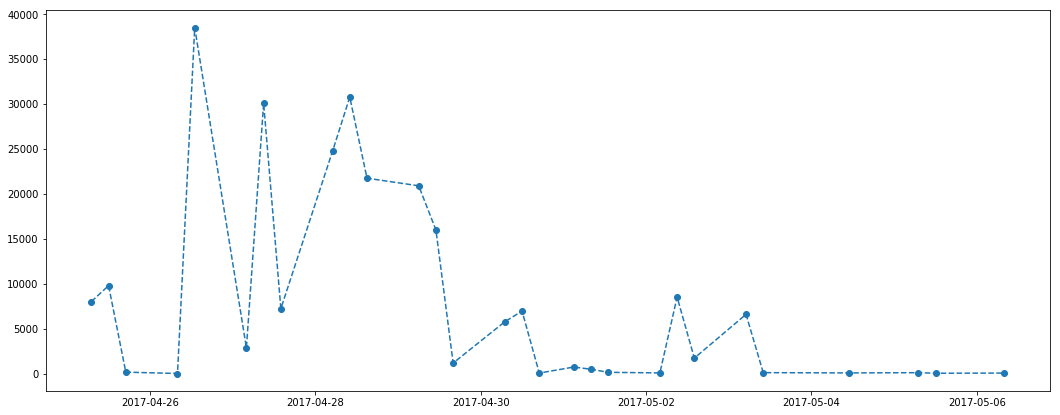

In [12]:
plt.close('all')
plt.figure(figsize=(18,7))
plt.plot(mean_gtu_datetime_vals, count_entries, marker='o', linestyle='--')
plt.show()

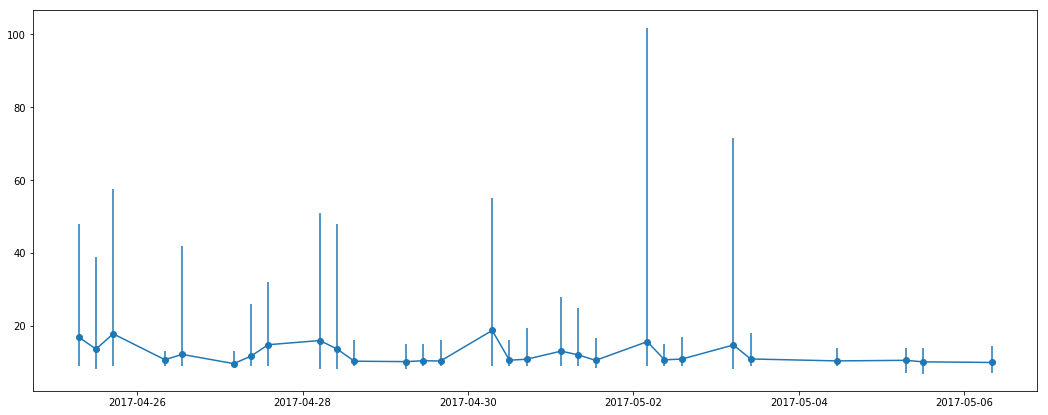

In [13]:
yerr=[np.array(mean_num_gtu_vals) - np.array(quantile_025_num_gtu_vals), 
      np.array(quantile_975_num_gtu_vals) - np.array(mean_num_gtu_vals)]
plt.figure(figsize=(18,7))
plt.errorbar(mean_gtu_datetime_vals, mean_num_gtu_vals, marker='o', yerr=yerr)
plt.show()

In [14]:
# Number of events by duration (bgf 0.5) 

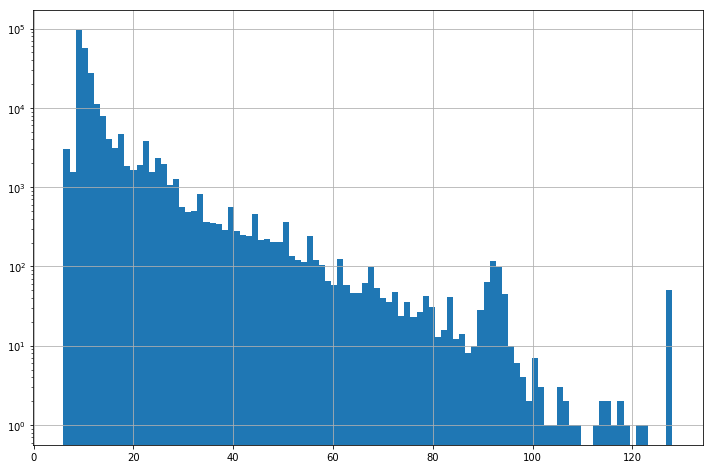

10.0
12.56575453940176


In [15]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_bg05_df #flight_data_df[flight_data_df.bg_size < 20]
h = filtered_df.num_gtu.hist(bins=100, figsize=(12,8))
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.num_gtu))
print(np.mean(filtered_df.num_gtu))

In [16]:
## Length distribution

In [17]:
## Long events by date

In [18]:
# Number of events by background (bgf 0.5)

In [19]:
## By date (from ver4)